# Indicators to Monitor:
- Use daily / weekly data
- Find firm-level fundamentals

In [1]:
import os
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Directory to save heatmaps
output_dir = "../output/heatmaps"
os.makedirs(output_dir, exist_ok=True)

# Define tickers
magnificent_7 = ['NVDA', 'META', 'TSLA', 'AMZN', 'GOOG', 'MSFT', 'AAPL']
indices_and_etfs = {
    'S&P 500': '^GSPC',
    'NASDAQ 100': '^NDX',
    'Global Market': 'ACWI',
    'Tech ETF': 'XLK'  # Technology Select Sector SPDR ETF
}

# Combine all tickers
all_tickers = magnificent_7 + list(indices_and_etfs.values())

# Find the most recent start date across all tickers
min_start_dates = []
for ticker in all_tickers:
    try:
        ticker_info = yf.Ticker(ticker).history(period='max')
        min_start_dates.append(ticker_info.index[0])
    except Exception as e:
        print(f"Error retrieving data for {ticker}: {e}")

most_recent_start_date = max(min_start_dates)
print(f"Most recent start date: {most_recent_start_date}")

# Set up years for the subplots
start_years = range(most_recent_start_date.year, 2025)

Most recent start date: 2012-05-18 00:00:00-04:00


In [ ]:
# Function to calculate correlations with color-coded background
def gradient_corr(x, y, **kws):
    r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()

    # Define custom color map
    cmap = sns.color_palette("coolwarm", as_cmap=True)

    # Map r to [0, 1], with 0.3 as the start of the gradient
    if r < 0.3:
        color = cmap(0)  # Pure blue
    else:
        normalized_r = (r - 0.3) / (1 - 0.3)  # Normalize to [0, 1] from [0.3, 1]
        color = cmap(normalized_r)

    ax.set_facecolor(color)  # Set background color
    ax.annotate(f"{r:.2f}", xy=(0.5, 0.5), xycoords=ax.transAxes,
                ha="center", va="center", fontsize=12, color="black")

# Generate and save heatmaps for each year
for year in start_years:
    # Download historical price data
    start_date = f"{year}-01-01"
    try:
        data = yf.download(all_tickers, start=start_date, end='2025-01-01', interval='1d')['Adj Close']

        # Add the aggregate of Magnificent 7 as an additional column
        data['Magnificent_7_Aggregate'] = data[magnificent_7].mean(axis=1)

        # Calculate daily returns
        returns = data.pct_change().dropna()

        # Create the pair plot
        g = sns.PairGrid(returns, diag_sharey=False)
        g.map_upper(sns.scatterplot, alpha=0.7)  # Scatterplots in upper triangle
        g.map_diag(sns.histplot, kde=True, color="cyan")  # Histograms on the diagonal
        g.map_lower(gradient_corr)  # Gradient-backed correlations in lower triangle

        # Save the heatmap
        g.fig.suptitle(f"Correlation Heatmap (Start: {year}-01-01)", y=1.02, fontsize=16)
        plt.tight_layout()
        g.savefig(os.path.join(output_dir, f"heatmap_{year}.png"))
        plt.close(g.fig)

    except Exception as e:
        print(f"Error for {year}: {e}")


## Interpretation of the Pairwise Analysis Plot

The pairwise analysis plot provides a comprehensive visualization of the relationships and distributions across variables. Each section conveys specific information:

### Upper Triangle: Scatterplots
The scatterplots in the upper triangle show the pairwise relationships between variables. 
- **Interpretation**: 
  - Tight, upward-sloping clusters indicate a strong **positive correlation**.
  - Downward-sloping clusters suggest a **negative correlation**.
  - Scattered points with no visible pattern imply **little to no correlation**.

### Diagonal: Histograms
The diagonal contains histograms with kernel density estimates (KDE) that display the distribution of individual variables.
- **Observation**: 
  - Most variables exhibit a **near-normal distribution** with **low skewness**, as evidenced by the symmetric shapes of the histograms and KDE curves.

### Lower Triangle: Correlation Coefficients with Gradient
The lower triangle presents the **Pearson correlation coefficients** for each pair of variables, accompanied by a **gradient color background**.
- **Gradient Meaning**:
  - **Blue**: Correlation values **below 0.3** indicate weak correlation.
  - **Red**: Correlation values **close to 1.0** indicate strong positive correlation.
  - Intermediate shades represent varying degrees of correlation.
- **Usage**: Quickly identify strong relationships (red) or weak relationships (blue).

### Summary
This plot provides a holistic view of the dataset:
- Scatterplots **reveal the nature and direction** of relationships between variables.
- Histograms **validate the normality** of individual variable distributions.
- Correlation coefficients **quantify the strength** of relationships, with the gradient offering visual cues for quick interpretation.


[*********************100%***********************]  11 of 11 completed
/var/folders/d2/xlkw5xhj2x7515008z10zp0w0000gn/T/ipykernel_62144/1935345406.py:7: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_returns = data_combined.resample('Q').ffill().pct_change().dropna()
/var/folders/d2/xlkw5xhj2x7515008z10zp0w0000gn/T/ipykernel_62144/1935345406.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_returns = data_combined.resample('Y').ffill().pct_change().dropna()


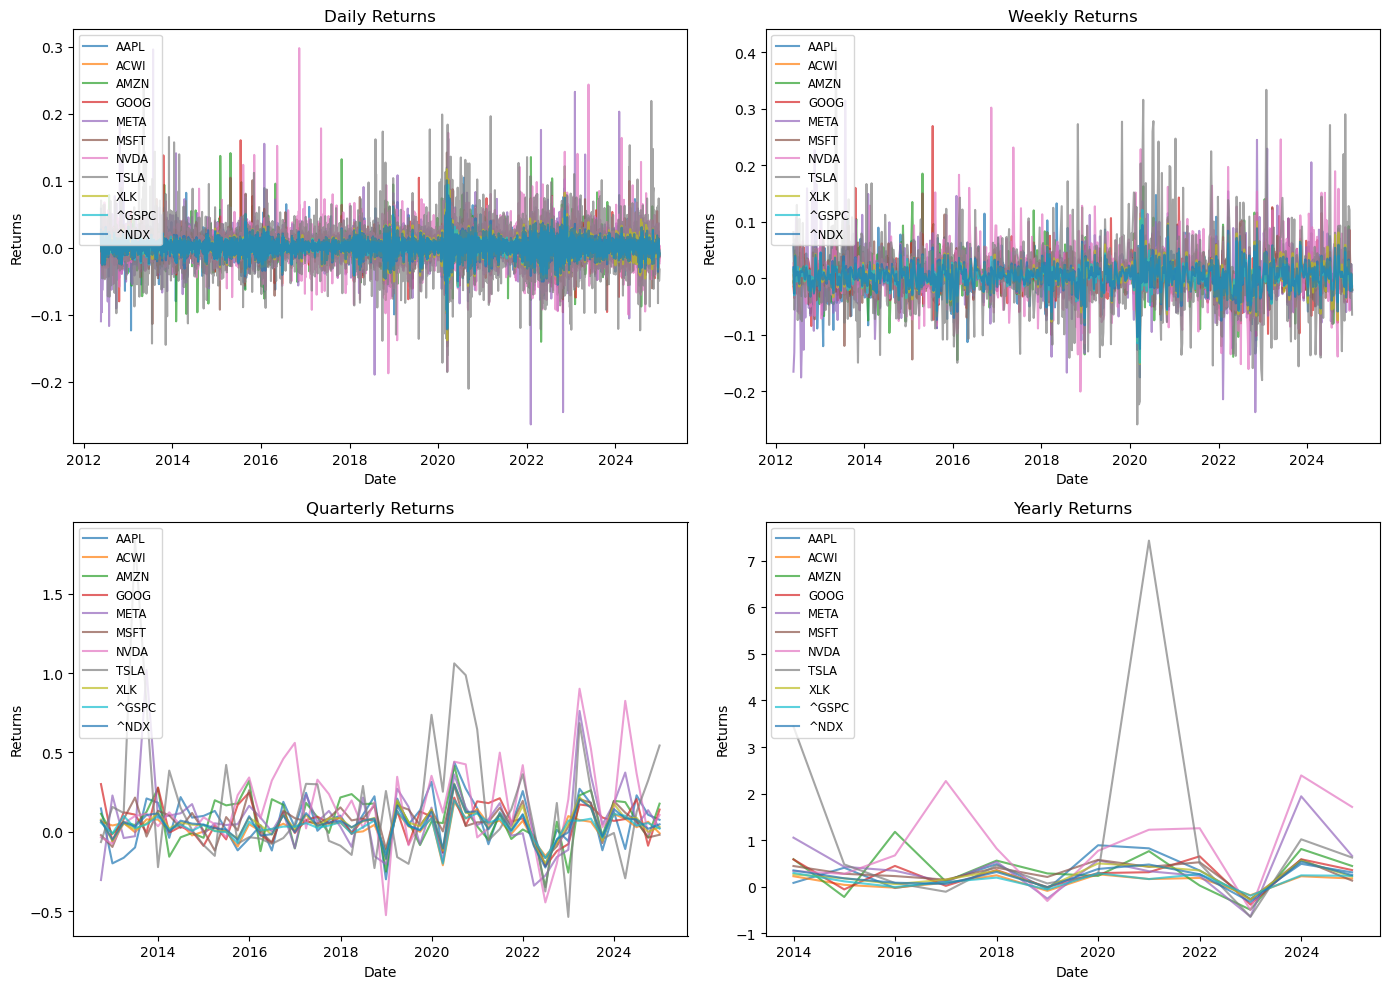

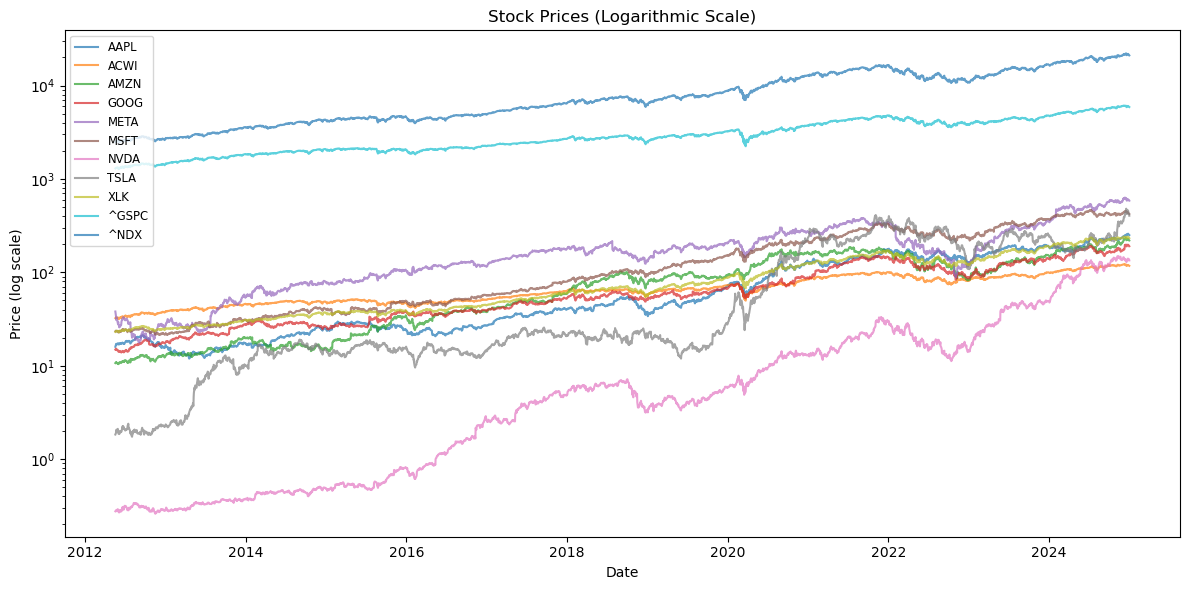

In [2]:
# Fetch data again from the common start date (most_recent_start_date) to 2025-01-01
data_combined = yf.download(all_tickers, start=most_recent_start_date, end='2025-01-01')['Adj Close']

# Calculate returns for different time periods
daily_returns = data_combined.pct_change().dropna()
weekly_returns = data_combined.resample('W').ffill().pct_change().dropna()
quarterly_returns = data_combined.resample('Q').ffill().pct_change().dropna()
yearly_returns = data_combined.resample('Y').ffill().pct_change().dropna()

# Plot daily, weekly, quarterly, and yearly returns in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Daily returns
axs[0, 0].plot(daily_returns, alpha=0.7)
axs[0, 0].set_title("Daily Returns")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Returns")
axs[0, 0].legend(daily_returns.columns, loc='upper left', fontsize='small')

# Weekly returns
axs[0, 1].plot(weekly_returns, alpha=0.7)
axs[0, 1].set_title("Weekly Returns")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Returns")
axs[0, 1].legend(weekly_returns.columns, loc='upper left', fontsize='small')

# Quarterly returns
axs[1, 0].plot(quarterly_returns, alpha=0.7)
axs[1, 0].set_title("Quarterly Returns")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Returns")
axs[1, 0].legend(quarterly_returns.columns, loc='upper left', fontsize='small')

# Yearly returns
axs[1, 1].plot(yearly_returns, alpha=0.7)
axs[1, 1].set_title("Yearly Returns")
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("Returns")
axs[1, 1].legend(yearly_returns.columns, loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

# Plot all prices on a single plot with a logarithmic scale
plt.figure(figsize=(12, 6))
plt.plot(data_combined, alpha=0.7)
plt.title("Stock Prices (Logarithmic Scale)")
plt.xlabel("Date")
plt.ylabel("Price (log scale)")
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.legend(data_combined.columns, loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


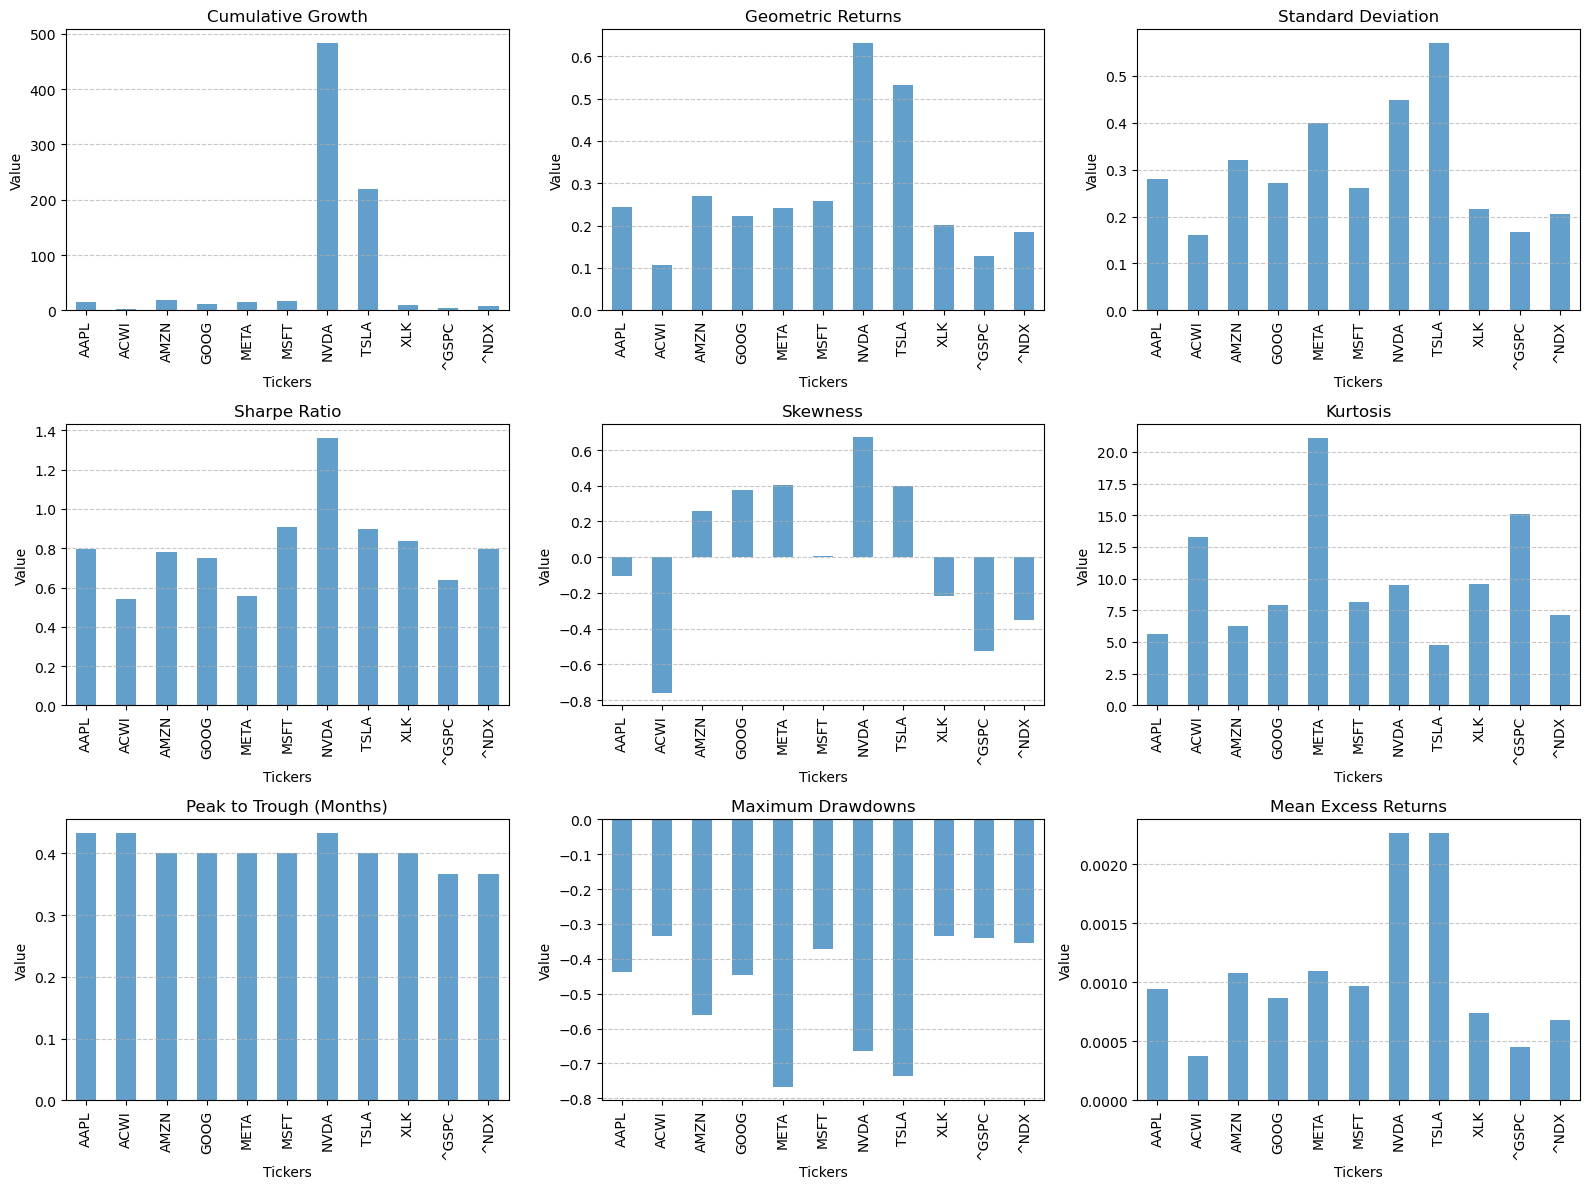

In [3]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Assume `data_combined` and `daily_returns` are already defined
metrics = {}

# 1. Cumulative Growth since Inception
cumulative_growth = (data_combined / data_combined.iloc[0]) - 1
metrics['Cumulative Growth'] = cumulative_growth.iloc[-1]

# 2. Geometric Returns since Inception
total_days = (data_combined.index[-1] - data_combined.index[0]).days
geometric_returns = ((data_combined.iloc[-1] / data_combined.iloc[0]) ** (1 / (total_days / 365))) - 1
metrics['Geometric Returns'] = geometric_returns

# 3. Standard Deviation (Annualized)
standard_deviation = daily_returns.std() * np.sqrt(252)
metrics['Standard Deviation'] = standard_deviation

# 4. Sharpe Ratio (Assume risk-free rate of 0.02)
risk_free_rate = 0.02
sharpe_ratio = (geometric_returns - risk_free_rate) / standard_deviation
metrics['Sharpe Ratio'] = sharpe_ratio

# 5. Skewness
skewness = daily_returns.skew()
metrics['Skewness'] = skewness

# 6. Kurtosis
kurtosis = daily_returns.kurtosis()
metrics['Kurtosis'] = kurtosis

# 7. Peak to Trough in Months (Using find_peaks)
peak_to_trough_durations = {}
for ticker in data_combined.columns:
    prices = data_combined[ticker]
    
    # Find peaks and troughs
    peaks, _ = find_peaks(prices)
    troughs, _ = find_peaks(-prices)
    
    # Calculate durations from peak to nearest following trough
    durations = []
    for peak in peaks:
        valid_troughs = [trough for trough in troughs if trough > peak]
        if valid_troughs:
            first_trough = valid_troughs[0]
            duration = (prices.index[first_trough] - prices.index[peak]).days / 30
            durations.append(duration)
    
    # Store the maximum duration for this ticker
    if durations:
        peak_to_trough_durations[ticker] = max(durations)
    else:
        peak_to_trough_durations[ticker] = 0  # No valid peak-to-trough found

metrics['Peak to Trough (Months)'] = pd.Series(peak_to_trough_durations)

# 8. Maximum Drawdowns
max_drawdowns = ((data_combined / data_combined.cummax()) - 1).min()
metrics['Maximum Drawdowns'] = max_drawdowns

# 9. Mean Excess Returns
mean_excess_returns = daily_returns.mean() - risk_free_rate / 252
metrics['Mean Excess Returns'] = mean_excess_returns

# Combine metrics into a DataFrame
metrics_df = pd.DataFrame(metrics)

# Plot metrics in subplots
fig, axs = plt.subplots(3, 3, figsize=(16, 12))

# Define metric titles and bar plot axes
metric_titles = [
    'Cumulative Growth', 'Geometric Returns', 'Standard Deviation', 
    'Sharpe Ratio', 'Skewness', 'Kurtosis', 
    'Peak to Trough (Months)', 'Maximum Drawdowns', 'Mean Excess Returns'
]

# Plot each metric
for i, ax in enumerate(axs.flatten()):
    metric = metric_titles[i]
    metrics_df[metric].plot(kind='bar', ax=ax, alpha=0.7)
    ax.set_title(metric)
    ax.set_ylabel('Value')
    ax.set_xlabel('Tickers')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Meaningful trends:
- 2008: Financial Crisis.
- 2010s: Growth of tech stocks post-crisis.
- 2020: COVID-19 pandemic and market rebound.
- 2023–2024: AI boom and dominance of the "Magnificent 7."

## Beta Calculation:

- Individual Betas of the "Magnificent 7" stocks (Nvidia, Meta, Tesla, Amazon, Alphabet, Microsoft, Apple).
- Aggregate Beta for the "Magnificent 7" vs. the remaining 493 stocks in the S&P 500.
- Market Beta: Use the S&P 500 index as the market proxy.

In [4]:
# Prepare returns
stock_returns = daily_returns[magnificent_7]  # Returns for the Magnificent 7
market_returns = daily_returns['^GSPC']  # Returns for the S&P 500

# Compute Individual Betas
individual_betas = {}
for stock in magnificent_7:
    cov = np.cov(stock_returns[stock], market_returns)[0, 1]  # Covariance
    var_market = market_returns.var()  # Variance of the market
    beta = cov / var_market
    individual_betas[stock] = beta

# Aggregate Beta for the Magnificent 7
# Use equal weights if market capitalization is unavailable
weights = np.ones(len(magnificent_7)) / len(magnificent_7)  # Equal weights
aggregate_beta = sum(weights[i] * individual_betas[stock] for i, stock in enumerate(magnificent_7))

# Market Beta (S&P 500 to itself, should be 1)
market_beta = np.cov(market_returns, market_returns)[0, 1] / market_returns.var()

# Output results
print("Individual Betas:")
for elem in individual_betas :
    print("\t", elem, ":", individual_betas[elem])
print("Aggregate Beta for Magnificent 7:", aggregate_beta)
print("Market Beta (S&P 500):", market_beta)

Individual Betas:
	 NVDA : 1.677697261675398
	 META : 1.24393601087617
	 TSLA : 1.4927639421642525
	 AMZN : 1.1654501433885145
	 GOOG : 1.1357833842926435
	 MSFT : 1.1927162117506362
	 AAPL : 1.1604968962369835
Aggregate Beta for Magnificent 7: 1.295549121483514
Market Beta (S&P 500): 1.0000000000000002


### Explanation of Results

#### **Individual Betas**
Each of the **Magnificent 7** stocks has a beta greater than 1, indicating higher volatility compared to the market:
- **Nvidia (NVDA)**: 1.68 — Highly sensitive to market movements, reflecting its growth in AI and semiconductors.
- **Meta (META)**: 1.24 — Moderately more volatile than the market.
- **Tesla (TSLA)**: 1.49 — High volatility, driven by its growth and EV market exposure.
- **Amazon (AMZN)**: 1.17 — Slightly above-market sensitivity.
- **Alphabet (GOOG)**: 1.14 — Relatively stable for a tech company.
- **Microsoft (MSFT)**: 1.19 — Balanced between stability and growth.
- **Apple (AAPL)**: 1.16 — Moderate volatility as a global tech leader.

#### **Aggregate Beta**
- **1.30**: The combined beta of the Magnificent 7 indicates they are collectively 30% more volatile than the market, reflecting their outsized influence on the S&P 500.

#### **Market Beta**
- **1.00**: The S&P 500 index's beta relative to itself is exactly 1, as expected.

#### **Approach**
1. Calculated **daily returns** for each stock and the S&P 500.
2. Computed **Individual Betas** as the covariance of each stock’s returns with the S&P 500, divided by the variance of the S&P 500.
3. Calculated the **Aggregate Beta** as the weighted average of the individual betas (equal weights).
4. Verified the **Market Beta** as 1.

This analysis highlights the significant volatility and influence of the Magnificent 7 stocks on the broader market.

In [ ]:
import pandas as pd
from ipywidgets import interact, IntSlider

# Resample daily returns to weekly returns
weekly_stock_returns = stock_returns.resample('W').ffill()
weekly_market_returns = market_returns.resample('W').ffill()

# Function to compute rolling beta with weekly returns
def compute_rolling_beta_weekly(window_weeks):
    rolling_betas = pd.DataFrame(index=weekly_stock_returns.index, columns=magnificent_7)
    
    for stock in magnificent_7:
        rolling_cov = (
            weekly_stock_returns[stock].rolling(window=window_weeks).cov(weekly_market_returns)
        )
        rolling_var = weekly_market_returns.rolling(window=window_weeks).var()
        rolling_betas[stock] = rolling_cov / rolling_var
    
    return rolling_betas

# Function to plot rolling beta with weekly returns
def plot_rolling_beta_weekly(window_weeks):
    rolling_betas = compute_rolling_beta_weekly(window_weeks)
    plt.figure(figsize=(14, 8))
    for stock in magnificent_7:
        plt.plot(rolling_betas[stock], label=f"{stock} (Rolling Beta)")
    plt.title(f"Weekly Rolling Beta (Window Size: {window_weeks} Weeks)")
    plt.xlabel("Date")
    plt.ylabel("Beta")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

# Create an interactive slider for the rolling weekly window
interact(
    plot_rolling_beta_weekly, 
    window_weeks=IntSlider(min=4, max=52, step=2, value=12, description="Window (Weeks)")
)

interactive(children=(IntSlider(value=12, description='Window (Weeks)', max=52, min=4, step=2), Output()), _do…

<function __main__.plot_rolling_beta_weekly(window_weeks)>

## Concentration Metrics:
- Weight of the "Magnificent 7" in the S&P 500 (percentage contribution to market cap).
- Compare the variance in beta contributions between the two groups.

## Correlation and Interdependence:
- Correlation matrix of the "Magnificent 7" returns to assess interdependencies (e.g., due to AI investment or sectoral overlaps).
- Historical trends in correlation pre- and post-AI boom.

## Volatility Measures:
- Historical volatility of individual "Magnificent 7" stocks.
- Impact on overall index volatility when these stocks experience large price movements.

## Performance Indicators:
- Monthly and yearly price returns for the "Magnificent 7" and the rest of the index.
- Event-specific changes (e.g., Tesla’s 2024 drop and its ripple effects).

## Impact Analysis:
- Historical data for significant price movements in these stocks (e.g., Tesla's drop in 2024).
- Scenario analysis: Simulate changes in beta and index returns when one or more stocks undergo substantial price shocks.

Set up WRDS :
- nano ~/.pgpass
- add : wrds-pgdata.wharton.upenn.edu:9737:wrds:your_username:your_password
- save file and set permissions : chmod 600 ~/.pgpass